In [1]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)

In [43]:
# X["disease_progression"] = y
# X
import pandas as pd
import os
from magpy.oracles.oracles import linear, BaseOracle
from magpy.search.pcskeleton import pc_skeleton, parallel_pc_skeleton
import logging
import networkx as nx
import matplotlib.pyplot as plt

try:
    _SETUP
except NameError:
    os.chdir("..")
    _SETUP = True


logging.basicConfig(level=logging.INFO)

In [55]:
from magpy.estimation.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

covariates = [
    "weather_1",
    "day_of_week",
    # "dph_col_grp_description",
    # "party1_move_pre_acc",
    # "party2_move_pre_acc",
    # "type_of_collision",
    # "road_cond_1",
]

effect_estimation = EffectEstimator(
    night_accidents,
    classifier=RandomForestClassifier,
    classifier_kwargs={"max_depth": 4},
    regressor=RandomForestRegressor,
    regressor_kwargs={"max_depth": 4},
)
results = effect_estimation.estimate_ate(
    treatment=CategoricalTreatmentParams(
        column="lighting",
        treatment_classes=["Dark - Street Lights"],
    ),
    outcome=CategoricalOutcomeParams(
        column="collision_severity",
        base_classes=["Fatal", "Injury (Severe)", "Injury (Other Visible)"],
    ),
    covariates=covariates,
    max_classes=5,
)

print(results.explain())

KeyboardInterrupt: 

In [5]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import cross_val_predict
from typing import List, Union, Optional
from scipy.special import expit, logit


def nn(x):
    return 1 / (numpy.sqrt(2 * numpy.pi)) * numpy.exp(-((x) ** 2) / 2)


class DebiasedML:
    """
    A class implementing Double/Debiased Machine Learning for treatment effect estimation.

    Parameters:
    -----------
    learner : BaseEstimator
        The base ML model to use for nuisance estimation (e.g., LGBMRegressor)
    cv_splits : int, default=5
        Number of cross-validation splits for nuisance estimation
    final_learner : Optional[BaseEstimator], default=None
        The ML model to use for final CATE estimation. If None, uses the same as learner

    Attributes:
    -----------
    debias_model_ : BaseEstimator
        Fitted model for debiasing treatment
    denoise_model_ : BaseEstimator
        Fitted model for denoising outcome
    final_model_ : BaseEstimator
        Fitted model for CATE estimation
    treatment_mean_ : float
        Mean of the treatment variable
    outcome_mean_ : float
        Mean of the outcome variable
    """

    def __init__(
        self,
        treatment_learner: BaseEstimator,
        outcome_learner: BaseEstimator,
        final_learner: Optional[BaseEstimator] = None,
        cv_splits: int = 5,
    ):
        self.treatment_learner = treatment_learner
        self.outcome_learner = outcome_learner
        self.final_learner = final_learner
        self.cv_splits = cv_splits
        self.epsilon = 1e-6
        self.outcome_type = None

    def fit(
        self,
        df: pd.DataFrame,
        treatment: str,
        outcome: str,
        covariates: List[str],
        outcome_type: str = "continuous",
    ) -> "DebiasedML":
        """
        Fit the Double/Debiased ML model.

        Parameters:
        -----------
        df : pd.DataFrame
            Input dataframe
        treatment : str
            Name of treatment column
        outcome : str
            Name of outcome column
        covariates : List[str]
            List of covariate column names

        Returns:
        --------
        self : DebiasedML
            The fitted model
        """
        # Store column names for later use
        self.treatment_ = treatment
        self.outcome_ = outcome
        self.covariates_ = covariates
        self.outcome_type = outcome_type

        # Store means for later use in counterfactual predictions
        self.treatment_mean_ = df[treatment].mean()
        self.outcome_mean_ = df[outcome].mean()

        # Create and fit the debiasing model for treatment
        self.debias_model_ = clone(self.treatment_learner)
        treatment_pred = cross_val_predict(
            self.debias_model_, df[covariates], df[treatment], cv=self.cv_splits
        )
        self.debias_model_.fit(df[covariates], df[treatment])

        # Modify the outcome prediction part based on outcome type
        self.denoise_model_ = clone(self.outcome_learner)
        if self.outcome_type in ["binary", "multiclass"]:
            # Get probability predictions instead of class predictions
            outcome_pred = cross_val_predict(
                self.denoise_model_,
                df[covariates],
                df[outcome],
                cv=self.cv_splits,
                method="predict_proba",  # Use probabilities for classification
            )
            # For binary, take only the positive class probability
            if self.outcome_type == "binary":
                outcome_pred = outcome_pred[:, 1]

            outcome_res = df[outcome] - outcome_pred

            # logloss = numpy.log(outcome_pred) * df[outcome] + numpy.log(
            #     1 - outcome_pred
            # ) * (1 - df[outcome])

            # outcome_res = (numpy.exp(-logloss) - 1) * (df[outcome] - 1 / 2) * 2

            # outcome_res = expit(outcome_res)

        else:  # continuous case
            outcome_pred = cross_val_predict(
                self.denoise_model_, df[covariates], df[outcome], cv=self.cv_splits
            )
            outcome_res = df[outcome] - outcome_pred

        self.denoise_model_.fit(df[covariates], df[outcome])

        # Calculate residuals
        treatment_res = df[treatment] - treatment_pred

        # Fit final CATE model using the R-learner approach
        weights = treatment_res**2

        signs = numpy.sign(treatment_res)
        tikhonov_adj = (1 - numpy.abs(signs)) * self.epsilon + signs * self.epsilon
        transformed_target = outcome_res / (treatment_res + tikhonov_adj)

        self.final_model_ = clone(self.final_learner)
        self.final_model_.fit(df[covariates], transformed_target, sample_weight=weights)

        return self

    def get_ite(self, df: pd.DataFrame) -> np.ndarray:
        """
        Get Individual Treatment Effects for new data.

        Parameters:
        -----------
        df : pd.DataFrame
            Dataframe containing covariates for prediction

        Returns:
        --------
        np.ndarray
            Array of individual treatment effects
        """
        if not hasattr(self, "final_model_"):
            raise ValueError("Model must be fitted before getting ITE")

        return self.final_model_.predict(df[self.covariates_])

    def counterfactual_prediction(
        self, df: pd.DataFrame, treatment_value: Union[float, np.ndarray]
    ) -> np.ndarray:
        """
        Make counterfactual predictions for specific treatment values.

        Parameters:
        -----------
        df : pd.DataFrame
            Dataframe containing covariates for prediction
        treatment_value : Union[float, np.ndarray]
            Treatment value(s) for counterfactual prediction

        Returns:
        --------
        np.ndarray
            Array of counterfactual predictions
        """
        if not hasattr(self, "final_model_"):
            raise ValueError(
                "Model must be fitted before making counterfactual predictions"
            )

        # Get baseline prediction
        if self.outcome_type == "binary":
            baseline = self.denoise_model_.predict_proba(df[self.covariates_])
            baseline = baseline[:, 1]

        elif self.outcome_type == "continuous":
            baseline = self.denoise_model_.predict(df[self.covariates_])

        # Get treatment effect
        ite = self.get_ite(df)

        # Calculate treatment deviation from mean
        if isinstance(treatment_value, (int, float)):
            treatment_dev = treatment_value - self.treatment_mean_
        else:
            treatment_dev = np.array(treatment_value) - self.treatment_mean_

        # Calculate counterfactual

        d = {
            "baseline": baseline,
            "addition": (ite * treatment_dev),
            "result": baseline + (ite * treatment_dev),
        }

        return d

In [4]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from numpy.random import normal
import pandas


def get_data():
    k = 1
    N = 100_000
    z = normal(0, 1, N)
    x = z + normal(0, 1, N)
    y = z + k * x + normal(0, 1, N)
    yB = y > 0
    df = pandas.DataFrame({"z": z, "x": x, "y": yB, "y_c": y})

    return df


df = get_data()

print(df["y"].mean())

# Initialize the model
model = DebiasedML(
    treatment_learner=LGBMRegressor(),
    outcome_learner=LGBMClassifier(),
    final_learner=LGBMRegressor(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=df,
    treatment="x",
    outcome="y",
    covariates=["z"],
    outcome_type="binary",
)

# Get individual treatment effects
ite = model.get_ite(df)

# Make counterfactual predictions
# cf_pred = model.counterfactual_prediction(df, treatment_value=50)

0.49961


NameError: name 'DebiasedML' is not defined

In [294]:
res = model.counterfactual_prediction(df=df, treatment_value=2)

In [299]:
(df["y_c"] + 1 > 1).mean() - (df["y_c"] > 1).mean()

0.18918000000000001

In [295]:
df["y"].mean()

0.56492

In [296]:
(res["addition"]).mean()

0.19378384614322294

In [292]:
res["result"].mean() - res["baseline"].mean()

0.026256429288702254

In [235]:
ite.mean()

0.027945690952334967

In [238]:
(df["y_c"] + 0.1 > 1).mean() - (df["y_c"] > 1).mean()

0.027109999999999967

In [530]:
train_df = df.sample(frac=0.5, random_state=42)
test_df = df.drop(train_df.index)

In [531]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

# Initialize the model
model = DebiasedML(
    treatment_learner=LinearRegression(),
    outcome_learner=LinearRegression(),
    final_learner=LinearRegression(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=train_df,
    treatment="age",
    outcome="disease_progression",
    covariates=["bmi", "bp"],
)

# Get individual treatment effects
ite = model.get_ite(test_df)

# Make counterfactual predictions
cf_pred = model.counterfactual_prediction(test_df, treatment_value=0)

KeyError: 'age'

In [30]:
test_df["cf_pred"] = cf_pred
test_df["cf_pred"].mean()

154.59084772832838

In [31]:
ite.mean()

125.80094742994571

In [532]:
import pandas

df = pandas.read_csv("data/diabetes.csv")

In [533]:
df["outcome"] = df["CLASS"] == "Y"

In [534]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

# Initialize the model
model = DebiasedML(
    treatment_learner=LGBMRegressor(),
    outcome_learner=LGBMClassifier(),
    final_learner=LGBMRegressor(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=df,
    treatment="BMI",
    outcome="outcome",
    covariates=["AGE"],
    outcome_type="binary",
)

# Get individual treatment effects
ite = model.get_ite(df)

# Make counterfactual predictions
cf_pred = model.counterfactual_prediction(df, treatment_value=50)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 1
[LightGBM] [Info] Start training from score 30.935100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [311]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from numpy.random import normal


def get_data():
    k = 0.3
    N = 100_000
    z = normal(0, 1, N)
    x = 1 * z + normal(0, 1, N)
    y = 1 * z + k * x + normal(0, 1, N)
    yB = y > 0
    df = pandas.DataFrame({"z": z, "x": x, "y": yB})

    return df


df = get_data()

# Initialize the model
model = DebiasedML(
    treatment_learner=LGBMRegressor(),
    outcome_learner=LGBMClassifier(),
    final_learner=LGBMRegressor(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=df,
    treatment="x",
    outcome="y",
    covariates=["z"],
    outcome_type="binary",
)

# Get individual treatment effects
ite = model.get_ite(df)

# Make counterfactual predictions
cf_pred = model.counterfactual_prediction(df, treatment_value=50)

numpy.exp(ite).mean()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score 0.000893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score 0.000347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

1.0757836493998312

In [310]:
df

,z,x,y
0,0.401731,-0.793020,True
1,-2.048442,-1.646158,False
2,0.173569,-0.442551,True
3,0.958120,0.306413,True
4,-0.545612,-1.540028,False
...,...,...,...
99995,-0.093600,-0.096106,True
99996,0.391440,-0.989830,False
99997,0.164485,0.773824,False
99998,-0.641621,-1.433162,False


0.12143650107261279

In [134]:
def prob_n_bigger_than_zero(kx):
    return (kx + normal(0, 1, 100_000) > 0).mean()

In [135]:
from matplotlib import pyplot as plt


z = [prob_n_bigger_than_zero(kx) for kx in numpy.arange(0, 1, 0.05)]

In [137]:
prob_n_bigger_than_zero(0.3)

0.61594

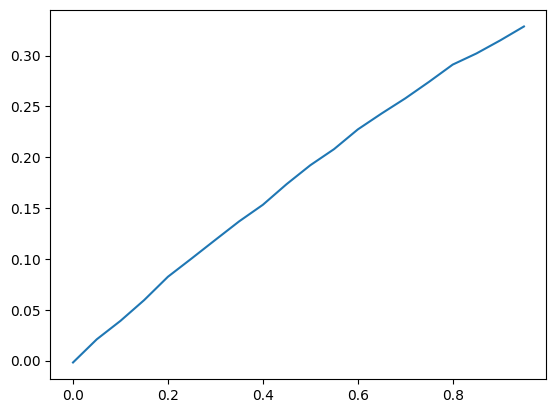

In [136]:
plt.plot(numpy.arange(0, 1, 0.05), numpy.array(z) - 0.5)

In [10]:
from magpy.estimation.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
    ContinuousOutcomeParams,
)

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np


class PolynomialRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree)
        self.linear = LinearRegression()

    def fit(self, X, y, sample_weight=None):
        # Reshape X if needed
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Transform features to polynomial features
        X_poly = self.poly.fit_transform(X)

        # Fit linear regression on polynomial features
        self.linear.fit(X_poly, y, sample_weight=sample_weight)
        return self

    def predict(self, X):
        # Reshape X if needed
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Transform features and predict
        X_poly = self.poly.transform(X)
        return self.linear.predict(X_poly)

In [37]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from magpy.estimation.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
    ContinuousOutcomeParams,
)


def get_data():
    noise = 0.01
    k = 1
    N = 100_000
    z = normal(0, 1, N)
    x = 1 * z + normal(0, 1, N)
    y = 1 * z + k * x * z * z + normal(0, 1, N)
    yB = y > 0
    df = pandas.DataFrame({"z": z, "x": x, "y": yB, "y_c": y})

    return df


df = get_data()

effect_estimation = EffectEstimator(
    data=df,
    classifier=LGBMClassifier,
    regressor=PolynomialRegressor,
)

results = effect_estimation.fit_predict(
    treatment=ContinuousTreatmentParams(column="x"),
    # outcome=CategoricalOutcomeParams(column="y", base_classes=[False]),
    outcome=ContinuousOutcomeParams(column="y_c"),
    covariates=["z"],
)

column='x' column='y_c'


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


In [38]:
results = effect_estimation.fit_predict(
    treatment=ContinuousTreatmentParams(column="x"),
    # outcome=CategoricalOutcomeParams(column="y", base_classes=[False]),
    outcome=ContinuousOutcomeParams(column="y_c"),
    covariates=["z"],
)

column='x' column='y_c'


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


In [39]:
results.covariate_groups["z"]

,mean_treatment_effect,std_treatment_effect,baseline_incidence_mean,baseline_incidence_number,baseline_treated_mean,baseline_treated_number,number_of_samples,significance
quantile,,,,,,,,
"(-4.625, -0.841]",2.212779,1.676951,-5.233847,-104676.935844,-1.397593,-27951.854312,20000,90.649568
"(-0.841, -0.254]",0.277535,0.185518,-0.724759,-14495.174222,-0.524470,-10489.404643,20000,93.266568
"(-0.254, 0.249]",-0.008445,0.019854,-0.005897,-117.936609,-0.007421,-148.418933,20000,66.471727
"(0.249, 0.841]",0.303120,0.196039,0.716910,14338.191985,0.524038,10480.750598,20000,93.896659
"(0.841, 3.999]",2.275033,1.693703,5.244674,104893.481951,1.401275,28025.500940,20000,91.039370


<Axes: xlabel='z', ylabel='effect'>

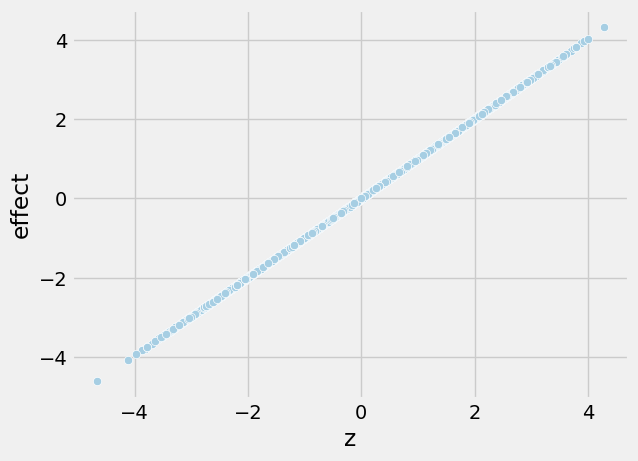

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.scatterplot(x="z", y="effect", data=results.data)

In [26]:
model = DebiasedML(
    treatment_learner=LGBMRegressor(),
    outcome_learner=LGBMClassifier(),
    final_learner=LGBMRegressor(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=df,
    treatment="x",
    outcome="y",
    covariates=["z"],
    outcome_type="binary",
)

# Get individual treatment effects
ite = model.get_ite(df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score -0.007120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score -0.009412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

NameError: name 'numpy' is not defined

In [354]:
ite.mean()

0.16264227044086368

In [556]:
columns = ["Urea", "Cr", "HbA1c", "Chol", "TG", "HDL", "LDL", "VLDL", "BMI"]

In [51]:
from magpy.estimation.effects import EffectEstimator
from magpy.estimation.effects import (
    ITEResults,
    ContinuousOutcomeParams,
    ContinuousTreatmentParams,
    CategoricalOutcomeParams,
    CategoricalTreatmentParams,
)

from xgboost import XGBClassifier, XGBRFRegressor


df = pandas.read_csv("data/diabetes.csv")

columns = ["Urea", "Cr", "HbA1c", "Chol", "TG", "HDL", "LDL", "VLDL", "BMI"]


effect_estimation = EffectEstimator(
    data=df,
    classifier=XGBClassifier,
    regressor=XGBRFRegressor,
)

results = {}
results_1 = {}
for col in columns:
    results[col] = effect_estimation.fit_predict(
        treatment=ContinuousTreatmentParams(column=col),
        # outcome=CategoricalOutcomeParams(column="y", base_classes=[False]),
        outcome=CategoricalOutcomeParams(column="CLASS", base_classes=["N"]),
        covariates=["AGE", "Gender"] + list(set(columns) - set([col])),
    )
    results_1[col] = effect_estimation.fit_predict(
        treatment=ContinuousTreatmentParams(column=col),
        # outcome=CategoricalOutcomeParams(column="y", base_classes=[False]),
        outcome=CategoricalOutcomeParams(column="CLASS", base_classes=["N"]),
        covariates=["AGE", "Gender"],
    )

column='Urea' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='Urea' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='Cr' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='Cr' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='HbA1c' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='HbA1c' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='Chol' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='Chol' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='TG' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='TG' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='HDL' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='HDL' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='LDL' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='LDL' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='VLDL' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='VLDL' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='BMI' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")
/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("qua

column='BMI' column='CLASS' base_classes=['N'] treatment_classes=[]


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


In [61]:
from magpy.oracles.mixed import MixedDataOracle
from magpy.search.pcskeleton import pc_skeleton


oracle = MixedDataOracle(df.drop(columns=["No_Pation", "ID"]))
mat, sepsets = pc_skeleton(
    oracle,
    intersection_or_union="intersection",
    nodes=df.drop(columns=["No_Pation", "ID"]).columns,
)
# skeleton.draw()

 58%|█████▊    | 38/66 [00:00<00:00, 202.03it/s]

 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value


100%|██████████| 66/66 [00:00<00:00, 1772.96it/s]


In [62]:
mat

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
Gender,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
AGE,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Urea,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cr,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HbA1c,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
Chol,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
TG,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
HDL,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
LDL,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
VLDL,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


In [52]:
for col in columns:
    print(col, results[col].data["effect"].mean(), results_1[col].data["effect"].mean())

Urea -0.004608371 -0.0054543074
Cr 8.2976614e-05 -0.00051524746
HbA1c -0.00043262576 0.03523011
Chol 0.03003706 0.02431885
TG 0.022227777 0.028655615
HDL -0.0019866747 -0.006998428
LDL 0.014109211 0.0074671567
VLDL -0.034883864 0.06337716
BMI 0.004961482 0.020210225


In [64]:
df = pandas.read_csv("data/BankChurners.csv")

In [66]:
list(df.columns)

['CLIENTNUM',
 'Attrition_Flag',
 'Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

In [67]:
excl = [
    "CLIENTNUM",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2",
]

In [75]:
from magpy.oracles.mixed import MixedDataOracle
from magpy.search.pcskeleton import pc_skeleton


oracle = MixedDataOracle(df.drop(columns=excl), threshold=0.1)
mat, sepsets = pc_skeleton(
    oracle,
    intersection_or_union="intersection",
    nodes=df.drop(columns=excl).columns,
)
# skeleton.draw()

  1%|          | 1/190 [00:00<00:30,  6.12it/s]

 ** On entry to DGESDDM parameter number 10 had an illegal value


 11%|█         | 21/190 [00:01<00:12, 13.26it/s]

 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value


 12%|█▏        | 23/190 [00:01<00:17,  9.71it/s]

 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value


 13%|█▎        | 25/190 [00:02<00:19,  8.28it/s]

 ** On entry to DGESDDM parameter number 10 had an illegal value


 65%|██████▌   | 124/190 [00:10<00:07,  9.19it/s]ERROR:root:Error running Credit_Limit -- Total_Trans_Amt | ('Avg_Open_To_Buy', 'Total_Revolving_Bal')
ERROR:root:not enough values to unpack (expected 1, got 0)
ERROR:root:Error running Credit_Limit -- Avg_Utilization_Ratio | ('Avg_Open_To_Buy', 'Total_Revolving_Bal')
ERROR:root:not enough values to unpack (expected 1, got 0)
ERROR:root:Error running Total_Revolving_Bal -- Total_Trans_Amt | ('Avg_Open_To_Buy', 'Credit_Limit')
ERROR:root:not enough values to unpack (expected 1, got 0)
 91%|█████████ | 172/190 [00:10<00:00, 46.03it/s]ERROR:root:Error running Total_Revolving_Bal -- Avg_Utilization_Ratio | ('Avg_Open_To_Buy', 'Credit_Limit')
ERROR:root:not enough values to unpack (expected 1, got 0)
ERROR:root:Error running Avg_Open_To_Buy -- Avg_Utilization_Ratio | ('Total_Revolving_Bal', 'Credit_Limit')
ERROR:root:not enough values to unpack (expected 1, got 0)
 75%|███████▌  | 143/190 [00:06<00:01, 25.26it/s]ERROR:root:Error running Credi

In [102]:
mat.loc["Attrition_Flag"].index

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [141]:
general_covariates = [
    "Customer_Age",
    "Gender",
    "Dependent_count",
    "Education_Level",
    "Marital_Status",
]

In [142]:
def associated_with_cols(col1, col2):
    col1_associated = mat.loc[col1][mat.loc[col1] == 1.0].index
    col2_associated = mat.loc[col2][mat.loc[col2] == 1.0].index
    return list(set(col1_associated) & set(col2_associated))


associated_with_cols("Income_Category", "Attrition_Flag")

['Gender',
 'Months_Inactive_12_mon',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Revolving_Bal']

In [156]:
from magpy.estimation.effects import EffectEstimator
from magpy.estimation.effects import (
    ITEResults,
    ContinuousOutcomeParams,
    ContinuousTreatmentParams,
    CategoricalOutcomeParams,
    CategoricalTreatmentParams,
)

from xgboost import XGBClassifier, XGBRegressor


effect_estimation = EffectEstimator(
    data=df,
    classifier=XGBClassifier,
    regressor=XGBRegressor,
)

results = {}
results_1 = {}
# for col in ["Income_Category"]:
# results[col] =
result = effect_estimation.fit_predict(
    # treatment=ContinuousTreatmentParams(column=col),
    treatment=CategoricalTreatmentParams(
        column="Income_Category", treatment_classes=["$120K +"]
    ),
    # outcome=CategoricalOutcomeParams(column="y", base_classes=[False]),
    outcome=CategoricalOutcomeParams(
        column="Attrition_Flag", treatment_classes=["Attrited Customer"]
    ),
    covariates=general_covariates,
)

INFO:causalml:Generating propensity score


column='Income_Category' base_classes=[] treatment_classes=['$120K +'] column='Attrition_Flag' base_classes=[] treatment_classes=['Attrited Customer']


/Users/andre/magpy/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andre/magpy/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andre/magpy/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andre/magpy/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andre/magpy/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andre/magpy/.venv/lib/python3.11/site-packages/s

In [157]:
result.data.effect.mean()

0.04203077204079174

In [153]:
result.covariate_groups.keys()

dict_keys(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status'])

In [155]:
result.covariate_groups["Customer_Age"]

,mean_treatment_effect,std_treatment_effect,baseline_incidence_mean,baseline_incidence_number,baseline_treated_mean,baseline_treated_number,number_of_samples,significance
quantile,,,,,,,,
"(25.999, 39.0]",0.136088,0.342997,0.136542,278,0.050098,102,2036,65.407626
"(39.0, 44.0]",-0.027724,0.259263,0.173446,371,0.061711,132,2139,54.255106
"(44.0, 48.0]",0.041185,0.280701,0.167099,322,0.055008,106,1927,55.827804
"(48.0, 53.0]",0.041330,0.238136,0.154175,325,0.116698,246,2108,56.883916
"(53.0, 73.0]",0.021589,0.294451,0.172666,331,0.073552,141,1917,52.920207


In [ ]:
def explain_model(model, X, feature_names=None):
    """
    Generate SHAP explanations for a scikit-learn model

    Parameters:
    -----------
    model : sklearn estimator
        Fitted scikit-learn model to explain
    X : pd.DataFrame or np.array
        Data to explain predictions for
    feature_names : list, optional
        List of feature names if X is not a DataFrame

    Returns:
    --------
    shap.Explanation
        SHAP explanation object containing various visualization methods
    """
    import shap

    # Convert numpy array to DataFrame if needed
    if not isinstance(X, pd.DataFrame) and feature_names is not None:
        X = pd.DataFrame(X, columns=feature_names)

    # Initialize explainer based on model type
    if hasattr(model, "predict_proba"):
        explainer = (
            shap.TreeExplainer(model)
            if hasattr(model, "estimators_")
            else shap.KernelExplainer(model.predict_proba, X)
        )
    else:
        explainer = (
            shap.TreeExplainer(model)
            if hasattr(model, "estimators_")
            else shap.KernelExplainer(model.predict, X)
        )

    # Calculate SHAP values
    shap_values = explainer.shap_values(X)

    # Print summary plots
    print("\nFeature Importance Plot:")
    shap.summary_plot(shap_values, X)

    if hasattr(model, "predict_proba"):
        print("\nFeature Importance Bar Plot:")
        shap.summary_plot(shap_values[1], X, plot_type="bar")

        print("\nDetailed Feature Impact Plot:")
        shap.dependence_plot("rank(0)", shap_values[1], X)
    else:
        print("\nFeature Importance Bar Plot:")
        shap.summary_plot(shap_values, X, plot_type="bar")

        print("\nDetailed Feature Impact Plot:")
        shap.dependence_plot("rank(0)", shap_values, X)

    return shap_values

In [ ]:
explain_model(effect_estimation.final_model_, df[general_covariates])

In [111]:
df.groupby("Total_Revolving_Bal")["Credit_Limit"].mean()

Total_Revolving_Bal
0.0        8039.114251
132.0      9580.000000
134.0      8018.000000
145.0      9104.000000
154.0     34516.000000
              ...     
2511.0     2835.000000
2512.0     3317.000000
2513.0     9904.000000
2514.0     3826.000000
2517.0     9115.500000
Name: Credit_Limit, Length: 1974, dtype: float64

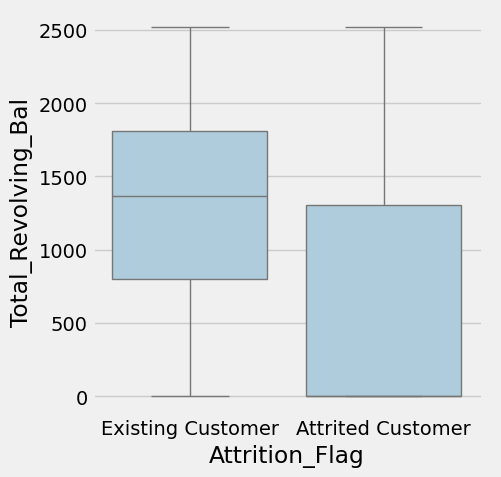

In [114]:
import seaborn as sns

sns.catplot(y="Total_Revolving_Bal", x="Attrition_Flag", data=df, kind="box")